<a href="https://colab.research.google.com/github/KotkaZ/journey-to-zero/blob/master/SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN Notebook

This notebook contains data processing and RRN Network model. The input data is a JourneyToZero Kaggle competition.

https://www.kaggle.com/competitions/predict-electricity-consumption

In [35]:
# Here we use Numpy arrays and Pandas dataframes to pass and modify data.
import numpy as np
import pandas as pd

# We use OneHotEncoder from preprocessing sklearn module.
from sklearn import preprocessing

# We use PCA from decomposition sklearn module.
from sklearn import decomposition


from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# We use plotting to validate neural network training curve.
from matplotlib import pyplot as plt
%matplotlib inline

import datetime

### Feature dropping

In Estonia, there are approximately 500-800 millimeters of rain on average. Our dataset consisted of only about 140mm of rain, which is definitely not correct. Also, the amount of snow was inappropriate for the same reason. We could integrate a new wether dataset or leave it as it is. The simpliest approch is to delete the whole columns, which we decided to do.

Some of the rows contained null values, which we also dropped. There was a case, when electricy prices hit market limit, which caused some outliners. It was wise to drop them.


In [21]:
def drop_features(dataset):
    dataset.drop(columns=['snow','prcp'], inplace=True)


In [22]:
def drop_rows(dataset):
    # Deal with NaN values
    initial_len = len(dataset)
    display(dataset.head())
    dataset.dropna(inplace=True)
    new_len = len(dataset)
    if (initial_len != new_len):
        print(f'Dropped {initial_len - new_len} row')

    # Deal with outliners
    dataset.drop(dataset[dataset['el_price'] > 1].index , inplace=True)

### Normalize 

Here we scale numeric values between 0 to 1 with MinMaxScaler

In [23]:
def normalize(dataset, scaler = None) -> (pd.DataFrame, preprocessing.MinMaxScaler):
    if scaler:
        dataset_scaled = scaler.transform(dataset)
        return (dataset_scaled, scaler)
    scaler = preprocessing.MinMaxScaler()
    dataset_scaled = scaler.fit_transform(dataset)
    return (dataset_scaled, scaler)

### PCA
As OneHotEncoder introduced a lot of new features, we decided to do PCA with leaving 90% of importance value.


In [24]:

def reduce_dimensions(dataset, pca = None) -> (pd.DataFrame, decomposition.PCA):
    if pca:
        dataset_reduced = pca.transform(dataset)
        return (dataset_reduced, pca)
    pca = decomposition.PCA(n_components=0.9)
    dataset_reduced = pca.fit_transform(dataset)
    return (dataset_reduced, pca)

### Preprocess
Here we combine all the previous methods into one. As trained encoder must be used on test set, we return it from the method.



In [25]:
def preprocess(dataset, encoder=None):
    drop_features(dataset)
    drop_rows(dataset)


### Import dataset

Here we import dataset, do inital processing and split into train and validation. As we predict consumption, we extract this column to separate numpy array.



In [26]:
# As we deal with time series, we use time as a dataframe index and sort based on that.
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name).set_index('time').sort_index()

In [27]:
def extract_labels(dataset) -> (pd.DataFrame, pd.Series):
    X_train = dataset.loc[:, ~dataset.columns.isin(['consumption'])]
    y_train = dataset['consumption']
    return (X_train, y_train)

In [28]:
train_df = read_dataset('train.csv')
preprocess(train_df)

X_train, y_train = extract_labels(train_df)

X_train_norm, scaler_data = normalize(X_train)


,temp,dwpt,rhum,wdir,wspd,wpgt,pres,coco,el_price,consumption
time,,,,,,,,,,
2021-09-01 00:00:00+03:00,11.2,10.3,94.0,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
2021-09-01 01:00:00+03:00,10.7,9.6,93.0,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2021-09-01 02:00:00+03:00,9.9,9.0,94.0,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
2021-09-01 03:00:00+03:00,10.0,8.4,90.0,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
2021-09-01 04:00:00+03:00,9.0,8.1,94.0,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


Dropped 198 row


In [29]:
X_test = read_dataset('test.csv')
preprocess(X_test)

X_test_norm, _ = normalize(X_test, scaler_data)

,temp,dwpt,rhum,wdir,wspd,wpgt,pres,coco,el_price
time,,,,,,,,,
2022-08-25 00:00:00+03:00,21.1,15.2,69.0,340.0,9.0,9.3,1022.0,2.0,0.25533
2022-08-25 01:00:00+03:00,20.1,15.1,73.0,30.0,6.0,14.8,1022.0,2.0,0.19492
2022-08-25 02:00:00+03:00,20.1,15.1,73.0,320.0,7.0,13.0,1022.0,2.0,0.18853
2022-08-25 03:00:00+03:00,18.7,17.0,90.0,0.0,4.0,11.1,1022.4,4.0,0.19947
2022-08-25 04:00:00+03:00,18.1,17.1,94.0,280.0,7.0,11.1,1022.0,3.0,0.21192


In [30]:
X_train, X_val,  y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.05)

In [31]:
X_train[0]

array([0.16173913, 0.2016129 , 0.8125    , 0.55555556, 0.22712934,
       0.19800333, 0.84334511, 0.        , 0.19800186])

In [32]:
X_train.shape[1]

9

### Training Neural Network
As we are using recurrent neural network nodes, we must use 3D data, where one dimension describes the timeseries.  

In [33]:
X_train = np.expand_dims(X_train, axis=-1)

X_train.shape

(7972, 9, 1)

In [36]:
mdl = Sequential()

mdl.add(SimpleRNN(6,  input_shape=(X_train.shape[1], X_train.shape[2])))
mdl.add(Dense(1))

mdl.compile(loss='mae', optimizer="adam")


In [37]:
history = mdl.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50, batch_size=1, verbose=True)


Epoch 1/50
7972/7972 [==============================] - 42s 5ms/step - loss: 0.6256 - val_loss: 0.6422
Epoch 2/50
7972/7972 [==============================] - 38s 5ms/step - loss: 0.5924 - val_loss: 0.5580
Epoch 3/50
7972/7972 [==============================] - 30s 4ms/step - loss: 0.5749 - val_loss: 0.5586
Epoch 4/50
7972/7972 [==============================] - 31s 4ms/step - loss: 0.5681 - val_loss: 0.5371
Epoch 5/50
7972/7972 [==============================] - 30s 4ms/step - loss: 0.5650 - val_loss: 0.5330
Epoch 6/50
7972/7972 [==============================] - 31s 4ms/step - loss: 0.5630 - val_loss: 0.5274
Epoch 7/50
7972/7972 [==============================] - 31s 4ms/step - loss: 0.5589 - val_loss: 0.5390
Epoch 8/50
7972/7972 [==============================] - 30s 4ms/step - loss: 0.5538 - val_loss: 0.5253
Epoch 9/50
7972/7972 [==============================] - 31s 4ms/step - loss: 0.5538 - val_loss: 0.5208
Epoch 10/50
7972/7972 [==============================] - 31s 4ms/step - l

Text(0.5, 1.0, 'Loss')

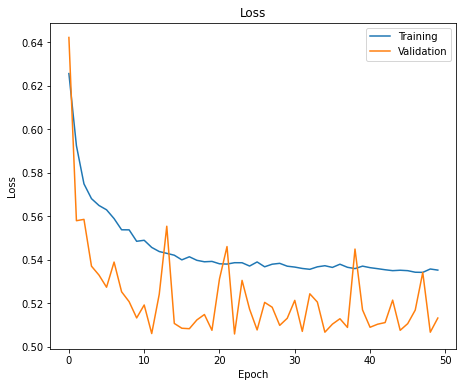

In [38]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')


### Prediction
We predict on the test dataset and write the output to csv file.



In [39]:
# With prediction, we must use batch_size 1 to make a use of time series sequence.
prediction = mdl.predict(X_test_norm, batch_size=1)
prediction

168/168 [==============================] - 1s 2ms/step


array([[ 0.539084  ],
       [ 0.3996331 ],
       [ 0.48594123],
       [ 0.35749125],
       [ 0.35976434],
       [ 0.32644016],
       [ 0.33672193],
       [ 0.34015185],
       [ 0.4306992 ],
       [ 0.30496308],
       [ 0.3794296 ],
       [ 0.44482222],
       [ 0.47414342],
       [ 0.49598193],
       [ 0.50825775],
       [ 0.51743007],
       [ 0.55639195],
       [ 0.6685405 ],
       [ 0.55168676],
       [ 0.37055048],
       [ 0.34584317],
       [ 0.33040738],
       [ 0.23759773],
       [ 0.2905953 ],
       [ 0.29200536],
       [ 0.30704752],
       [ 0.3102349 ],
       [ 0.34406194],
       [ 0.3620389 ],
       [ 0.36586902],
       [ 0.34921566],
       [ 0.31747234],
       [ 0.30756232],
       [ 0.33537483],
       [ 0.25713614],
       [ 0.41696462],
       [ 0.4419517 ],
       [ 0.44912285],
       [ 0.48998347],
       [ 0.50393194],
       [ 0.59951437],
       [ 0.5509713 ],
       [ 0.5109916 ],
       [ 0.4616827 ],
       [ 0.3754418 ],
       [ 0

In [40]:
# We must reload the test dataframe, as we droped the time column.
X_test = read_dataset('test.csv')

predictions_dict = {'time':X_test.index,'consumption':[el[0]for el in prediction]}
pred_df = pd.DataFrame(predictions_dict)
pred_df.to_csv('submission_081222_v4.csv',index=False)